# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [10]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


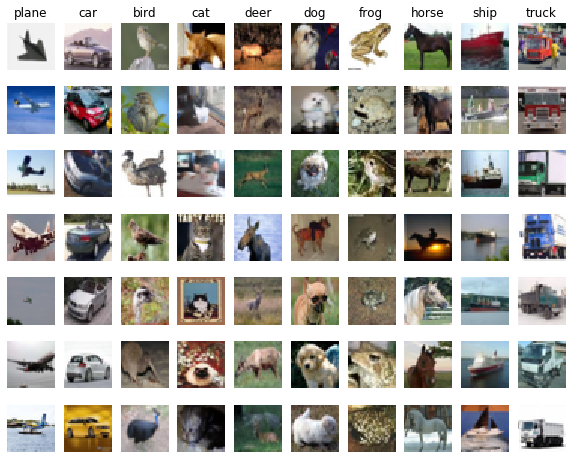

In [11]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../datasets/cifar10'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original dataset.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original dataset.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # Our test set will be num_test points from the original dataset.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [12]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [19]:
# first iteration
lr = [5e-7, 8e-7, 1e-6, 3e-6, 5e-6, 7e-6, 9e-6]
reg = [2.5e-9, 5e-9, 2.5e-8, 5e-8, 2.5e-7, 5e-7, 2.5e-6, 5e-6, 2.5e-5, 5e-5, 2.5e-4, 5e-4, 2.5e-3, 5e-3, 2.5e-2, 5e-2, 2.5e-1, 5e-1, 2.5, 5, 2.5e1, 5e1]
# second iteration
lr = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
reg = [1, 5, 5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
# third iteration
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
reg = [1e-2, 1e-1, 1, 1e1]
# fourth iteration
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
reg = [1e-4, 1e-3, 1e-2]
# fifth iteration
lr = [1e-2, 1e-1]
reg = [1e-3, 1e-2]

In [13]:
# Use the validation set to tune the learning rate and regularization strength. You can 
# reuse the softmax_hyperparameter_tuning that you implemented in
# exercise_code.classifiers.softmax

from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax = None

################################################################################
# TODO: Train a softmax classifier on the features and tune hyperparameters to #
# obtain a strong model. You can alter and reuse the                           #
# softmax_hyperparameter_tuning function. Store your best network in the       #
# best_softmax variable.                                                       #
################################################################################
lr = [1e-2, 1e-1]
reg = [1e-3, 1e-2]
num_iters = 4000

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val, lr, reg, num_iters)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 4000: loss 2.301900
iteration 100 / 4000: loss 1.893860
iteration 200 / 4000: loss 1.726573
iteration 300 / 4000: loss 1.637099
iteration 400 / 4000: loss 1.504141
iteration 500 / 4000: loss 1.511900
iteration 600 / 4000: loss 1.517407
iteration 700 / 4000: loss 1.473348
iteration 800 / 4000: loss 1.541558
iteration 900 / 4000: loss 1.520458
iteration 1000 / 4000: loss 1.515013
iteration 1100 / 4000: loss 1.424819
iteration 1200 / 4000: loss 1.268842
iteration 1300 / 4000: loss 1.395764
iteration 1400 / 4000: loss 1.441676
iteration 1500 / 4000: loss 1.395197
iteration 1600 / 4000: loss 1.323907
iteration 1700 / 4000: loss 1.380691
iteration 1800 / 4000: loss 1.397649
iteration 1900 / 4000: loss 1.358008
iteration 2000 / 4000: loss 1.451678
iteration 2100 / 4000: loss 1.456754
iteration 2200 / 4000: loss 1.470684
iteration 2300 / 4000: loss 1.372298
iteration 2400 / 4000: loss 1.208665
iteration 2500 / 4000: loss 1.341640
iteration 2600 / 4000: loss 1.407224
iteration 270

In [15]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.506


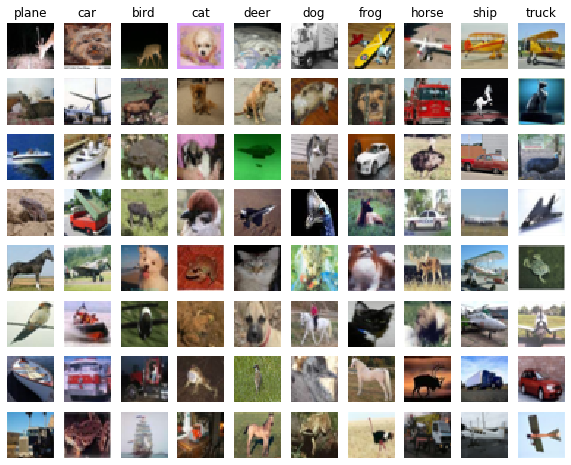

In [16]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

The misclassified results look like this:
Car and truck are held for each other
Stuff with large area of blue background is chosen to be a plane
Brownish pictures are selected as horses
pictures with large green background are selected as deers

This means that the classifier has learned some general information of the images, but overall does not generalize well enough. The misclassified samples make sense as the classifier often learned big areas of the same color like the sky as background or a forest and made the decision based on this.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned and behave almost the same as having a single bias term.

In [ ]:
# first iteration
hds = [300, 500]
lr = [1e-3, 1e-2, 1e-1]
lrd = [0.95, 0.9]
reg = [1e-6, 1e-5, 1e-4, 5, 5e1, 5e2]
num_iters = 1500
# second iteration
hds = [500, 800, 1000, 1200]
lr = [1e-2, 1e-1, 5e-1, 1]
lrd = [0.95, 0.9]
reg = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
num_iters = 1500
# third iteration
hds = [1200, 1500, 2000]
lr = [5e-1, 1, 1e1, 1e2]
lrd = [0.95, 0.9, 0.85]
reg = [1e-10, 1e-7, 1e-6, 1e-3, 1, 1e2]
num_iters = 1000
# fourth iteration
hds = [1400, 1600, 1800]
lr = [5e-1, 1]
lrd = [0.95, 0.9, 0.85]
reg = [1e-10, 1e-6, 1e-3]
num_iters = 1000

In [17]:
from exercise_code.classifiers.neural_net import TwoLayerNet, neuralnetwork_hyperparameter_tuning

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best         #
# model in the best_net variable.                                              #
################################################################################

hds = [1400, 1600, 1800]
lr = [5e-1, 1]
lrd = [0.95, 0.9, 0.85]
reg = [1e-10, 1e-6, 1e-3]
num_iters = [8000]

best_net, results, all_nets = neuralnetwork_hyperparameter_tuning(X_train_feats, y_train, X_val_feats, y_val, hidden_size=hds, learning_rates=lr, learning_rate_decays=lrd, regularization_strengths=reg, num_iters=num_iters, batch_size=200)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Actual Num_iters 8.000000e+03
Number of hidden layers 1.400000e+03
Actual lr decay 9.500000e-01
Actual learning rate 5.000000e-01
Actual reg strength 1.000000e-10
iteration 0 / 8000: loss 2.302585
iteration 100 / 8000: loss 1.495368
iteration 200 / 8000: loss 1.385645
iteration 300 / 8000: loss 1.318522
iteration 400 / 8000: loss 1.395586
iteration 500 / 8000: loss 1.238875
iteration 600 / 8000: loss 1.412176
iteration 700 / 8000: loss 1.174907
iteration 800 / 8000: loss 0.993242
iteration 900 / 8000: loss 1.072154
iteration 1000 / 8000: loss 1.081105
iteration 1100 / 8000: loss 0.980082
iteration 1200 / 8000: loss 1.055105
iteration 1300 / 8000: loss 0.953410
iteration 1400 / 8000: loss 0.854699
iteration 1500 / 8000: loss 1.040815
iteration 1600 / 8000: loss 1.008529
iteration 1700 / 8000: loss 0.893865
iteration 1800 / 8000: loss 0.824693
iteration 1900 / 8000: loss 0.949311
iteration 2000 / 8000: loss 0.788257
iteration 2100 / 8000: loss 0.731710
iteration 2200 / 8000: loss 0.71378

iteration 5700 / 8000: loss 0.784056
iteration 5800 / 8000: loss 0.685975
iteration 5900 / 8000: loss 0.684925
iteration 6000 / 8000: loss 0.653531
iteration 6100 / 8000: loss 0.686381
iteration 6200 / 8000: loss 0.679496
iteration 6300 / 8000: loss 0.688903
iteration 6400 / 8000: loss 0.701801
iteration 6500 / 8000: loss 0.676200
iteration 6600 / 8000: loss 0.681106
iteration 6700 / 8000: loss 0.709403
iteration 6800 / 8000: loss 0.717994
iteration 6900 / 8000: loss 0.714200
iteration 7000 / 8000: loss 0.641179
iteration 7100 / 8000: loss 0.686973
iteration 7200 / 8000: loss 0.687345
iteration 7300 / 8000: loss 0.610200
iteration 7400 / 8000: loss 0.675776
iteration 7500 / 8000: loss 0.682174
iteration 7600 / 8000: loss 0.648863
iteration 7700 / 8000: loss 0.663531
iteration 7800 / 8000: loss 0.693345
iteration 7900 / 8000: loss 0.645713
Actual learning rate 1.000000e+00
Actual reg strength 1.000000e-10
iteration 0 / 8000: loss 2.302585
iteration 100 / 8000: loss 1.462065
iteration 20

iteration 3600 / 8000: loss 0.746629
iteration 3700 / 8000: loss 0.794492
iteration 3800 / 8000: loss 0.861633
iteration 3900 / 8000: loss 0.695866
iteration 4000 / 8000: loss 0.874082
iteration 4100 / 8000: loss 0.718945
iteration 4200 / 8000: loss 0.782202
iteration 4300 / 8000: loss 0.936134
iteration 4400 / 8000: loss 0.800767
iteration 4500 / 8000: loss 0.812326
iteration 4600 / 8000: loss 0.761213
iteration 4700 / 8000: loss 0.737233
iteration 4800 / 8000: loss 0.636600
iteration 4900 / 8000: loss 0.746701
iteration 5000 / 8000: loss 0.741411
iteration 5100 / 8000: loss 0.709834
iteration 5200 / 8000: loss 0.707939
iteration 5300 / 8000: loss 0.686543
iteration 5400 / 8000: loss 0.665237
iteration 5500 / 8000: loss 0.760164
iteration 5600 / 8000: loss 0.695383
iteration 5700 / 8000: loss 0.737766
iteration 5800 / 8000: loss 0.652898
iteration 5900 / 8000: loss 0.698903
iteration 6000 / 8000: loss 0.593462
iteration 6100 / 8000: loss 0.703336
iteration 6200 / 8000: loss 0.708305
i

iteration 1500 / 8000: loss 1.111775
iteration 1600 / 8000: loss 1.182689
iteration 1700 / 8000: loss 1.003169
iteration 1800 / 8000: loss 0.912646
iteration 1900 / 8000: loss 1.118976
iteration 2000 / 8000: loss 0.931505
iteration 2100 / 8000: loss 0.990523
iteration 2200 / 8000: loss 0.923684
iteration 2300 / 8000: loss 1.134076
iteration 2400 / 8000: loss 0.931867
iteration 2500 / 8000: loss 0.961780
iteration 2600 / 8000: loss 1.040901
iteration 2700 / 8000: loss 0.936267
iteration 2800 / 8000: loss 0.871543
iteration 2900 / 8000: loss 0.962769
iteration 3000 / 8000: loss 0.901180
iteration 3100 / 8000: loss 0.902539
iteration 3200 / 8000: loss 0.978485
iteration 3300 / 8000: loss 0.919248
iteration 3400 / 8000: loss 0.872232
iteration 3500 / 8000: loss 0.879959
iteration 3600 / 8000: loss 0.818174
iteration 3700 / 8000: loss 0.863813
iteration 3800 / 8000: loss 0.850905
iteration 3900 / 8000: loss 0.795925
iteration 4000 / 8000: loss 0.859371
iteration 4100 / 8000: loss 0.922032
i

iteration 7500 / 8000: loss 0.071586
iteration 7600 / 8000: loss 0.075824
iteration 7700 / 8000: loss 0.068044
iteration 7800 / 8000: loss 0.086279
iteration 7900 / 8000: loss 0.081288
Actual reg strength 1.000000e-03
iteration 0 / 8000: loss 2.302587
iteration 100 / 8000: loss 1.646930
iteration 200 / 8000: loss 1.533512
iteration 300 / 8000: loss 1.346112
iteration 400 / 8000: loss 1.305926
iteration 500 / 8000: loss 1.096305
iteration 600 / 8000: loss 1.242473
iteration 700 / 8000: loss 1.279647
iteration 800 / 8000: loss 1.235622
iteration 900 / 8000: loss 1.129235
iteration 1000 / 8000: loss 1.072752
iteration 1100 / 8000: loss 1.126585
iteration 1200 / 8000: loss 1.036923
iteration 1300 / 8000: loss 1.053817
iteration 1400 / 8000: loss 1.074123
iteration 1500 / 8000: loss 1.125940
iteration 1600 / 8000: loss 1.038228
iteration 1700 / 8000: loss 0.907185
iteration 1800 / 8000: loss 1.099711
iteration 1900 / 8000: loss 0.889497
iteration 2000 / 8000: loss 0.978837
iteration 2100 / 

iteration 5400 / 8000: loss 0.676959
iteration 5500 / 8000: loss 0.620625
iteration 5600 / 8000: loss 0.654423
iteration 5700 / 8000: loss 0.790216
iteration 5800 / 8000: loss 0.641766
iteration 5900 / 8000: loss 0.720940
iteration 6000 / 8000: loss 0.685005
iteration 6100 / 8000: loss 0.641619
iteration 6200 / 8000: loss 0.722980
iteration 6300 / 8000: loss 0.747799
iteration 6400 / 8000: loss 0.625610
iteration 6500 / 8000: loss 0.650170
iteration 6600 / 8000: loss 0.680137
iteration 6700 / 8000: loss 0.550448
iteration 6800 / 8000: loss 0.586327
iteration 6900 / 8000: loss 0.766698
iteration 7000 / 8000: loss 0.596293
iteration 7100 / 8000: loss 0.657959
iteration 7200 / 8000: loss 0.714130
iteration 7300 / 8000: loss 0.565125
iteration 7400 / 8000: loss 0.733756
iteration 7500 / 8000: loss 0.633609
iteration 7600 / 8000: loss 0.561591
iteration 7700 / 8000: loss 0.742386
iteration 7800 / 8000: loss 0.593769
iteration 7900 / 8000: loss 0.665297
Actual reg strength 1.000000e-03
itera

iteration 3300 / 8000: loss 0.374687
iteration 3400 / 8000: loss 0.306266
iteration 3500 / 8000: loss 0.291736
iteration 3600 / 8000: loss 0.361126
iteration 3700 / 8000: loss 0.329065
iteration 3800 / 8000: loss 0.289329
iteration 3900 / 8000: loss 0.294110
iteration 4000 / 8000: loss 0.291125
iteration 4100 / 8000: loss 0.374031
iteration 4200 / 8000: loss 0.343088
iteration 4300 / 8000: loss 0.260776
iteration 4400 / 8000: loss 0.272873
iteration 4500 / 8000: loss 0.319025
iteration 4600 / 8000: loss 0.270932
iteration 4700 / 8000: loss 0.391311
iteration 4800 / 8000: loss 0.329082
iteration 4900 / 8000: loss 0.291633
iteration 5000 / 8000: loss 0.278152
iteration 5100 / 8000: loss 0.258034
iteration 5200 / 8000: loss 0.280020
iteration 5300 / 8000: loss 0.282613
iteration 5400 / 8000: loss 0.295891
iteration 5500 / 8000: loss 0.230672
iteration 5600 / 8000: loss 0.275876
iteration 5700 / 8000: loss 0.307417
iteration 5800 / 8000: loss 0.248977
iteration 5900 / 8000: loss 0.287181
i

iteration 1100 / 8000: loss 1.142147
iteration 1200 / 8000: loss 1.088349
iteration 1300 / 8000: loss 0.966191
iteration 1400 / 8000: loss 0.893350
iteration 1500 / 8000: loss 0.859461
iteration 1600 / 8000: loss 1.015329
iteration 1700 / 8000: loss 0.870587
iteration 1800 / 8000: loss 0.840822
iteration 1900 / 8000: loss 0.970918
iteration 2000 / 8000: loss 0.916195
iteration 2100 / 8000: loss 0.742177
iteration 2200 / 8000: loss 0.744691
iteration 2300 / 8000: loss 0.771049
iteration 2400 / 8000: loss 0.576720
iteration 2500 / 8000: loss 0.632640
iteration 2600 / 8000: loss 0.687859
iteration 2700 / 8000: loss 0.574445
iteration 2800 / 8000: loss 0.561240
iteration 2900 / 8000: loss 0.435244
iteration 3000 / 8000: loss 0.534473
iteration 3100 / 8000: loss 0.585938
iteration 3200 / 8000: loss 0.438128
iteration 3300 / 8000: loss 0.474403
iteration 3400 / 8000: loss 0.350097
iteration 3500 / 8000: loss 0.504929
iteration 3600 / 8000: loss 0.358490
iteration 3700 / 8000: loss 0.407209
i

iteration 7100 / 8000: loss 0.012728
iteration 7200 / 8000: loss 0.013416
iteration 7300 / 8000: loss 0.013440
iteration 7400 / 8000: loss 0.018462
iteration 7500 / 8000: loss 0.018226
iteration 7600 / 8000: loss 0.017915
iteration 7700 / 8000: loss 0.016457
iteration 7800 / 8000: loss 0.014111
iteration 7900 / 8000: loss 0.017748
Actual reg strength 1.000000e-06
iteration 0 / 8000: loss 2.302585
iteration 100 / 8000: loss 1.676132
iteration 200 / 8000: loss 1.353406
iteration 300 / 8000: loss 1.420731
iteration 400 / 8000: loss 1.376314
iteration 500 / 8000: loss 1.030053
iteration 600 / 8000: loss 1.187308
iteration 700 / 8000: loss 1.172613
iteration 800 / 8000: loss 1.210175
iteration 900 / 8000: loss 0.934260
iteration 1000 / 8000: loss 0.865162
iteration 1100 / 8000: loss 0.878202
iteration 1200 / 8000: loss 0.767520
iteration 1300 / 8000: loss 0.810879
iteration 1400 / 8000: loss 0.659083
iteration 1500 / 8000: loss 0.668717
iteration 1600 / 8000: loss 0.675508
iteration 1700 / 

iteration 5000 / 8000: loss 0.471576
iteration 5100 / 8000: loss 0.439435
iteration 5200 / 8000: loss 0.409578
iteration 5300 / 8000: loss 0.348783
iteration 5400 / 8000: loss 0.498385
iteration 5500 / 8000: loss 0.496585
iteration 5600 / 8000: loss 0.379861
iteration 5700 / 8000: loss 0.391879
iteration 5800 / 8000: loss 0.446157
iteration 5900 / 8000: loss 0.328051
iteration 6000 / 8000: loss 0.357690
iteration 6100 / 8000: loss 0.399747
iteration 6200 / 8000: loss 0.483015
iteration 6300 / 8000: loss 0.406107
iteration 6400 / 8000: loss 0.443862
iteration 6500 / 8000: loss 0.397958
iteration 6600 / 8000: loss 0.358275
iteration 6700 / 8000: loss 0.437428
iteration 6800 / 8000: loss 0.402895
iteration 6900 / 8000: loss 0.327134
iteration 7000 / 8000: loss 0.409607
iteration 7100 / 8000: loss 0.393337
iteration 7200 / 8000: loss 0.340676
iteration 7300 / 8000: loss 0.427661
iteration 7400 / 8000: loss 0.306260
iteration 7500 / 8000: loss 0.333467
iteration 7600 / 8000: loss 0.348087
i

iteration 2900 / 8000: loss 0.226722
iteration 3000 / 8000: loss 0.272969
iteration 3100 / 8000: loss 0.312029
iteration 3200 / 8000: loss 0.223594
iteration 3300 / 8000: loss 0.243792
iteration 3400 / 8000: loss 0.149481
iteration 3500 / 8000: loss 0.184381
iteration 3600 / 8000: loss 0.165514
iteration 3700 / 8000: loss 0.234231
iteration 3800 / 8000: loss 0.221185
iteration 3900 / 8000: loss 0.189707
iteration 4000 / 8000: loss 0.195189
iteration 4100 / 8000: loss 0.168476
iteration 4200 / 8000: loss 0.200150
iteration 4300 / 8000: loss 0.140658
iteration 4400 / 8000: loss 0.148855
iteration 4500 / 8000: loss 0.132734
iteration 4600 / 8000: loss 0.093136
iteration 4700 / 8000: loss 0.109618
iteration 4800 / 8000: loss 0.107306
iteration 4900 / 8000: loss 0.149339
iteration 5000 / 8000: loss 0.103748
iteration 5100 / 8000: loss 0.089344
iteration 5200 / 8000: loss 0.109528
iteration 5300 / 8000: loss 0.119175
iteration 5400 / 8000: loss 0.099017
iteration 5500 / 8000: loss 0.126669
i

iteration 700 / 8000: loss 1.248455
iteration 800 / 8000: loss 1.154618
iteration 900 / 8000: loss 1.034304
iteration 1000 / 8000: loss 1.074817
iteration 1100 / 8000: loss 1.130444
iteration 1200 / 8000: loss 0.999990
iteration 1300 / 8000: loss 0.974026
iteration 1400 / 8000: loss 0.992274
iteration 1500 / 8000: loss 0.931333
iteration 1600 / 8000: loss 1.124579
iteration 1700 / 8000: loss 0.973307
iteration 1800 / 8000: loss 0.888011
iteration 1900 / 8000: loss 0.883710
iteration 2000 / 8000: loss 0.929014
iteration 2100 / 8000: loss 0.890655
iteration 2200 / 8000: loss 0.758669
iteration 2300 / 8000: loss 1.025468
iteration 2400 / 8000: loss 0.840464
iteration 2500 / 8000: loss 0.750438
iteration 2600 / 8000: loss 0.847714
iteration 2700 / 8000: loss 0.781440
iteration 2800 / 8000: loss 0.816051
iteration 2900 / 8000: loss 0.758489
iteration 3000 / 8000: loss 0.782642
iteration 3100 / 8000: loss 0.741825
iteration 3200 / 8000: loss 0.765002
iteration 3300 / 8000: loss 0.825792
iter

iteration 6800 / 8000: loss 0.816584
iteration 6900 / 8000: loss 0.874271
iteration 7000 / 8000: loss 0.919669
iteration 7100 / 8000: loss 0.962094
iteration 7200 / 8000: loss 0.928642
iteration 7300 / 8000: loss 0.914122
iteration 7400 / 8000: loss 0.970507
iteration 7500 / 8000: loss 0.886786
iteration 7600 / 8000: loss 0.825428
iteration 7700 / 8000: loss 0.876826
iteration 7800 / 8000: loss 0.869534
iteration 7900 / 8000: loss 0.839307
Actual learning rate 1.000000e+00
Actual reg strength 1.000000e-10
iteration 0 / 8000: loss 2.302584
iteration 100 / 8000: loss 1.452713
iteration 200 / 8000: loss 1.467821
iteration 300 / 8000: loss 1.346513
iteration 400 / 8000: loss 1.232750
iteration 500 / 8000: loss 1.046001
iteration 600 / 8000: loss 1.092174
iteration 700 / 8000: loss 1.190974
iteration 800 / 8000: loss 1.068279
iteration 900 / 8000: loss 1.040831
iteration 1000 / 8000: loss 0.892572
iteration 1100 / 8000: loss 0.841855
iteration 1200 / 8000: loss 0.688364
iteration 1300 / 800

iteration 4700 / 8000: loss 0.734413
iteration 4800 / 8000: loss 0.685101
iteration 4900 / 8000: loss 0.732249
iteration 5000 / 8000: loss 0.778846
iteration 5100 / 8000: loss 0.746498
iteration 5200 / 8000: loss 0.654476
iteration 5300 / 8000: loss 0.711664
iteration 5400 / 8000: loss 0.657645
iteration 5500 / 8000: loss 0.729143
iteration 5600 / 8000: loss 0.718529
iteration 5700 / 8000: loss 0.728988
iteration 5800 / 8000: loss 0.658653
iteration 5900 / 8000: loss 0.714174
iteration 6000 / 8000: loss 0.746475
iteration 6100 / 8000: loss 0.756657
iteration 6200 / 8000: loss 0.684115
iteration 6300 / 8000: loss 0.684169
iteration 6400 / 8000: loss 0.649937
iteration 6500 / 8000: loss 0.724502
iteration 6600 / 8000: loss 0.702458
iteration 6700 / 8000: loss 0.779080
iteration 6800 / 8000: loss 0.668914
iteration 6900 / 8000: loss 0.642260
iteration 7000 / 8000: loss 0.679388
iteration 7100 / 8000: loss 0.661370
iteration 7200 / 8000: loss 0.653903
iteration 7300 / 8000: loss 0.666988
i

iteration 2500 / 8000: loss 1.090389
iteration 2600 / 8000: loss 1.063692
iteration 2700 / 8000: loss 0.953161
iteration 2800 / 8000: loss 0.981295
iteration 2900 / 8000: loss 0.855569
iteration 3000 / 8000: loss 0.972374
iteration 3100 / 8000: loss 0.888222
iteration 3200 / 8000: loss 0.888542
iteration 3300 / 8000: loss 0.963568
iteration 3400 / 8000: loss 0.817427
iteration 3500 / 8000: loss 0.885196
iteration 3600 / 8000: loss 0.780107
iteration 3700 / 8000: loss 0.759689
iteration 3800 / 8000: loss 0.876791
iteration 3900 / 8000: loss 0.933103
iteration 4000 / 8000: loss 0.830740
iteration 4100 / 8000: loss 0.687871
iteration 4200 / 8000: loss 0.866084
iteration 4300 / 8000: loss 0.907405
iteration 4400 / 8000: loss 0.856146
iteration 4500 / 8000: loss 0.795730
iteration 4600 / 8000: loss 0.723816
iteration 4700 / 8000: loss 0.805632
iteration 4800 / 8000: loss 0.763020
iteration 4900 / 8000: loss 0.777166
iteration 5000 / 8000: loss 0.751151
iteration 5100 / 8000: loss 0.716025
i

iteration 400 / 8000: loss 1.465067
iteration 500 / 8000: loss 1.227213
iteration 600 / 8000: loss 1.326025
iteration 700 / 8000: loss 1.289926
iteration 800 / 8000: loss 1.251218
iteration 900 / 8000: loss 1.270706
iteration 1000 / 8000: loss 1.125444
iteration 1100 / 8000: loss 1.216678
iteration 1200 / 8000: loss 0.989508
iteration 1300 / 8000: loss 1.193517
iteration 1400 / 8000: loss 1.457666
iteration 1500 / 8000: loss 1.040823
iteration 1600 / 8000: loss 1.099425
iteration 1700 / 8000: loss 0.948460
iteration 1800 / 8000: loss 1.076945
iteration 1900 / 8000: loss 1.067255
iteration 2000 / 8000: loss 1.043440
iteration 2100 / 8000: loss 0.900910
iteration 2200 / 8000: loss 0.954459
iteration 2300 / 8000: loss 1.000159
iteration 2400 / 8000: loss 0.851425
iteration 2500 / 8000: loss 0.899082
iteration 2600 / 8000: loss 1.005537
iteration 2700 / 8000: loss 0.953568
iteration 2800 / 8000: loss 1.001796
iteration 2900 / 8000: loss 0.889363
iteration 3000 / 8000: loss 0.973194
iterati

iteration 6300 / 8000: loss 0.422394
iteration 6400 / 8000: loss 0.370341
iteration 6500 / 8000: loss 0.378531
iteration 6600 / 8000: loss 0.350792
iteration 6700 / 8000: loss 0.471726
iteration 6800 / 8000: loss 0.458479
iteration 6900 / 8000: loss 0.350882
iteration 7000 / 8000: loss 0.381202
iteration 7100 / 8000: loss 0.334933
iteration 7200 / 8000: loss 0.379343
iteration 7300 / 8000: loss 0.353169
iteration 7400 / 8000: loss 0.281449
iteration 7500 / 8000: loss 0.351828
iteration 7600 / 8000: loss 0.407870
iteration 7700 / 8000: loss 0.416138
iteration 7800 / 8000: loss 0.447114
iteration 7900 / 8000: loss 0.396604
Actual reg strength 1.000000e-03
iteration 0 / 8000: loss 2.302586
iteration 100 / 8000: loss 1.498518
iteration 200 / 8000: loss 1.499079
iteration 300 / 8000: loss 1.379199
iteration 400 / 8000: loss 1.328421
iteration 500 / 8000: loss 1.227180
iteration 600 / 8000: loss 1.171514
iteration 700 / 8000: loss 1.114181
iteration 800 / 8000: loss 1.161975
iteration 900 / 

iteration 4200 / 8000: loss 0.136369
iteration 4300 / 8000: loss 0.142730
iteration 4400 / 8000: loss 0.111331
iteration 4500 / 8000: loss 0.132190
iteration 4600 / 8000: loss 0.117478
iteration 4700 / 8000: loss 0.099828
iteration 4800 / 8000: loss 0.107433
iteration 4900 / 8000: loss 0.113235
iteration 5000 / 8000: loss 0.095715
iteration 5100 / 8000: loss 0.102975
iteration 5200 / 8000: loss 0.144849
iteration 5300 / 8000: loss 0.097831
iteration 5400 / 8000: loss 0.100706
iteration 5500 / 8000: loss 0.106215
iteration 5600 / 8000: loss 0.094932
iteration 5700 / 8000: loss 0.095160
iteration 5800 / 8000: loss 0.073250
iteration 5900 / 8000: loss 0.077270
iteration 6000 / 8000: loss 0.069010
iteration 6100 / 8000: loss 0.071737
iteration 6200 / 8000: loss 0.091868
iteration 6300 / 8000: loss 0.082104
iteration 6400 / 8000: loss 0.071344
iteration 6500 / 8000: loss 0.080456
iteration 6600 / 8000: loss 0.074603
iteration 6700 / 8000: loss 0.095766
iteration 6800 / 8000: loss 0.075646
i

iteration 2100 / 8000: loss 0.930091
iteration 2200 / 8000: loss 0.832137
iteration 2300 / 8000: loss 0.802412
iteration 2400 / 8000: loss 0.758757
iteration 2500 / 8000: loss 0.899771
iteration 2600 / 8000: loss 0.834685
iteration 2700 / 8000: loss 0.757922
iteration 2800 / 8000: loss 0.833131
iteration 2900 / 8000: loss 0.699716
iteration 3000 / 8000: loss 0.815872
iteration 3100 / 8000: loss 0.805156
iteration 3200 / 8000: loss 0.730879
iteration 3300 / 8000: loss 0.918857
iteration 3400 / 8000: loss 0.603078
iteration 3500 / 8000: loss 0.717162
iteration 3600 / 8000: loss 0.723143
iteration 3700 / 8000: loss 0.785561
iteration 3800 / 8000: loss 0.735267
iteration 3900 / 8000: loss 0.758175
iteration 4000 / 8000: loss 0.742092
iteration 4100 / 8000: loss 0.707927
iteration 4200 / 8000: loss 0.696692
iteration 4300 / 8000: loss 0.760609
iteration 4400 / 8000: loss 0.778886
iteration 4500 / 8000: loss 0.726755
iteration 4600 / 8000: loss 0.703133
iteration 4700 / 8000: loss 0.605309
i

iteration 100 / 8000: loss 1.385589
iteration 200 / 8000: loss 1.435455
iteration 300 / 8000: loss 1.321518
iteration 400 / 8000: loss 1.278284
iteration 500 / 8000: loss 1.179425
iteration 600 / 8000: loss 1.111813
iteration 700 / 8000: loss 1.124709
iteration 800 / 8000: loss 0.925222
iteration 900 / 8000: loss 0.949509
iteration 1000 / 8000: loss 0.900691
iteration 1100 / 8000: loss 0.984469
iteration 1200 / 8000: loss 0.818743
iteration 1300 / 8000: loss 0.852695
iteration 1400 / 8000: loss 0.752896
iteration 1500 / 8000: loss 0.656576
iteration 1600 / 8000: loss 0.758768
iteration 1700 / 8000: loss 0.581064
iteration 1800 / 8000: loss 0.607371
iteration 1900 / 8000: loss 0.798649
iteration 2000 / 8000: loss 0.539967
iteration 2100 / 8000: loss 0.568909
iteration 2200 / 8000: loss 0.477076
iteration 2300 / 8000: loss 0.469566
iteration 2400 / 8000: loss 0.470807
iteration 2500 / 8000: loss 0.559125
iteration 2600 / 8000: loss 0.448036
iteration 2700 / 8000: loss 0.372580
iteration 

In [18]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.637


## Save the model

When you are satisfied with your training you can save your model. 
You need to get a score of at least **55%** to pass this submission.
<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle ...</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [19]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)